In [1]:
import pandas as pd
import numpy as np
from math import isnan
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from itertools import chain
from src.swap_utils import get_pool_value_by_coin

from src.data_extractors import get_pools, get_prices, get_price_enriched

#### Get Bostrom and Osmosis Pools Data

In [2]:
pools_df = get_pools(display_data=False, bostrom_related_osmo_pools=None)
pools_df = \
    pools_df[
        (pools_df.network == 'bostrom') |
        ((pools_df.network =='space-pussy') & (pools_df.id != '4')) |
        (pools_df.reserve_coin_denoms.map(lambda denoms: 'boot in osmosis' in denoms))]
pools_df

,network,id,type_id,balances,reserve_coin_denoms,swap_fee
0,bostrom,1,1,"[{'denom': 'boot', 'amount': '3829592876070'},...","[boot, hydrogen]",0.0030
1,bostrom,2,1,"[{'denom': 'boot', 'amount': '6353090227'}, {'...","[boot, milliampere]",0.0030
2,bostrom,3,1,"[{'denom': 'boot', 'amount': '24295012421'}, {...","[boot, tocyb]",0.0030
3,bostrom,4,1,"[{'denom': 'hydrogen', 'amount': '110505057555...","[hydrogen, tocyb]",0.0030
4,bostrom,5,1,"[{'denom': 'hydrogen', 'amount': '180068121931...","[hydrogen, milliampere]",0.0030
5,bostrom,6,1,"[{'denom': 'hydrogen', 'amount': '146470691282...","[hydrogen, millivolt]",0.0030
6,bostrom,7,1,"[{'denom': 'hydrogen', 'amount': '489277710807...","[hydrogen, uosmo in bostrom]",0.0030
7,bostrom,8,1,[],"[hydrogen, deprecated uatom in bostrom]",0.0030
8,bostrom,9,1,[],"[uosmo in bostrom, deprecated uatom in bostrom]",0.0030
9,bostrom,10,1,"[{'denom': 'milliampere', 'amount': '209348962...","[milliampere, millivolt]",0.0030


#### Calculate Prices

In [3]:
price_df = get_prices(pools_df=pools_df, display_data=True, zero_fee=True)

,aevmos in bostrom,boot in osmosis,hydrogen,dot in osmosis,ugraviton in bostrom,udsm in bostrom,weth in osmosis,liquidpussy,ibc/6AE98883D4D5D5FF9E50D7130F1305DA2FFA0C652D1DD9C123657C6B4EB2DF8A,tocyb,uion,weth.grv in osmosis,liquidpussy in bostrom,pussy in bostrom,milliampere,uatom in osmosis,weth.grv in bostrom,ibc/E97634A40119F1898989C2A23224ED83FDD0A57EA46B3A094E287288D1672B44,uatom in bostrom,boot,ujuno in bostrom,uosmo,pussy,ujuno in osmosis,uosmo in bostrom,deprecated uatom in bostrom,millivolt
aevmos in bostrom,1,NaN,25431620968.960709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
boot in osmosis,NaN,1,NaN,0.012073,NaN,NaN,0.0,NaN,0.0,NaN,21024.371795,0.0,NaN,NaN,NaN,244.02507,NaN,0.799706,NaN,1,NaN,17.168817,NaN,26.062982,NaN,NaN,NaN
hydrogen,0.0,NaN,1,NaN,1.669101,4.55615,NaN,NaN,NaN,10.479732,NaN,NaN,0.000092,0.000408,4015.944645,NaN,0.0,NaN,1938.101878,7.636848,183.236796,NaN,NaN,NaN,137.618073,NaN,38546.535684
dot in osmosis,NaN,82.828652,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ugraviton in bostrom,NaN,NaN,0.599125,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
udsm in bostrom,NaN,NaN,0.219484,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weth in osmosis,NaN,31587791.449642,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
liquidpussy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1,NaN,6513.172102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.363909,NaN,NaN,NaN,44757.59983
ibc/6AE98883D4D5D5FF9E50D7130F1305DA2FFA0C652D1DD9C123657C6B4EB2DF8A,NaN,139311759567.364044,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tocyb,NaN,NaN,0.095422,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7355,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Prices without References to the Networks

In [4]:
price_enriched_df = get_price_enriched(price_df=price_df, display_data=True)

,aevmos in bostrom,boot in osmosis,hydrogen,dot in osmosis,ugraviton in bostrom,udsm in bostrom,weth in osmosis,liquidpussy,ibc/6AE98883D4D5D5FF9E50D7130F1305DA2FFA0C652D1DD9C123657C6B4EB2DF8A,tocyb,uion,weth.grv in osmosis,liquidpussy in bostrom,pussy in bostrom,milliampere,uatom in osmosis,weth.grv in bostrom,ibc/E97634A40119F1898989C2A23224ED83FDD0A57EA46B3A094E287288D1672B44,uatom in bostrom,boot,ujuno in bostrom,uosmo,pussy,ujuno in osmosis,uosmo in bostrom,deprecated uatom in bostrom,millivolt
aevmos in bostrom,1,NaN,25431620968.960709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
boot in osmosis,NaN,1,0.130944,0.012073,NaN,NaN,0.0,NaN,0.0,1.359618,21024.371795,0.0,NaN,0.000053,525.073123,244.02507,0.0,0.799706,244.02507,1,26.062982,17.168817,0.000053,26.062982,17.168817,NaN,5034.974876
hydrogen,0.0,7.636848,1,0.092201,1.669101,4.55615,0.0,0.000092,0.0,10.479732,160559.924934,0.0,0.000092,0.000408,4015.944645,1938.101878,0.0,6.107234,1938.101878,7.636848,183.236796,137.618073,0.000408,183.236796,137.618073,NaN,38546.535684
dot in osmosis,NaN,82.828652,10.845922,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.828652,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ugraviton in bostrom,NaN,NaN,0.599125,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
udsm in bostrom,NaN,NaN,0.219484,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weth in osmosis,NaN,31587791.449642,4136234.318051,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31587791.449642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
liquidpussy,NaN,NaN,10857.714305,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1,3.363909,6513.172102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.363909,NaN,NaN,NaN,44757.59983
ibc/6AE98883D4D5D5FF9E50D7130F1305DA2FFA0C652D1DD9C123657C6B4EB2DF8A,NaN,139311759567.364044,18242050310.772545,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,139311759567.364044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tocyb,NaN,0.7355,0.095422,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7355,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Get Pools Liquidity

network,id,reserve_coin_denoms,"liquidity, GH"
space-pussy,1,"[liquidpussy, pussy]",99.1
space-pussy,3,"[liquidpussy, millivolt]",9.8
space-pussy,2,"[liquidpussy, milliampere]",7.4
osmosis,596,"[uatom in osmosis, boot in osmosis]","4,554.6"
osmosis,912,"[weth in osmosis, boot in osmosis]","3,839.3"
osmosis,597,"[boot in osmosis, uosmo]","1,423.8"
osmosis,911,"[weth.grv in osmosis, boot in osmosis]","1,255.6"
osmosis,919,"[dot in osmosis, boot in osmosis]",187.7
osmosis,745,[ibc/6AE98883D4D5D5FF9E50D7130F1305DA2FFA0C652D...,0.4
osmosis,595,"[uatom in osmosis, boot in osmosis]",0.2


Total liquidity: 150,705 GH


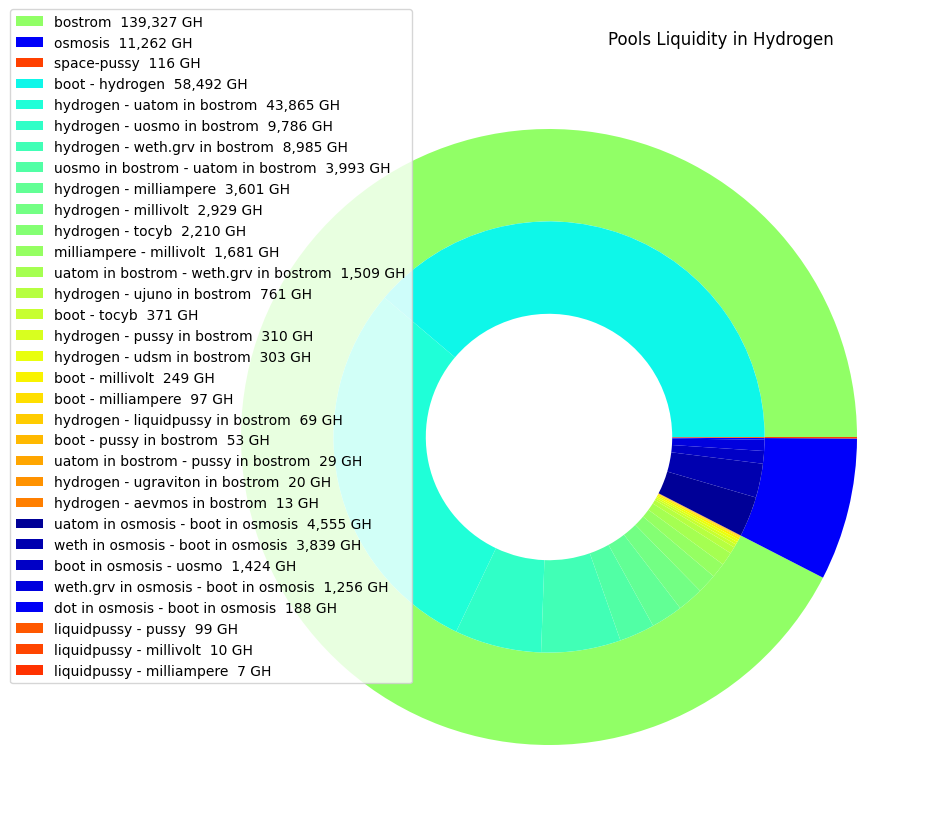

In [5]:
def get_pool_liquidity(balances: list, target_denom: str = 'hydrogen', main_liquidity_denom: str = 'hydrogen',
                       price_enriched_df: pd.DataFrame = price_enriched_df) -> float:
    if not balances:
        return 0
    denoms = [item['denom'] for item in balances]
    balances_dict = {item['denom']: int(item['amount']) for item in balances}
    if target_denom in denoms:
        return balances_dict[target_denom] * 2
    elif not isnan(price_enriched_df.loc[target_denom, denoms[0]]):
        return balances_dict[denoms[0]] * price_enriched_df.loc[target_denom, denoms[0]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, denoms[1]]):
        return balances_dict[denoms[1]] * price_enriched_df.loc[target_denom, denoms[1]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, main_liquidity_denom]) and not isnan(
            price_df.loc[main_liquidity_denom, denoms[0]]):
        return balances_dict[denoms[0]] * price_enriched_df.loc[target_denom, main_liquidity_denom] * \
               price_enriched_df.loc[main_liquidity_denom, denoms[0]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, main_liquidity_denom]) and not isnan(price_df.loc[main_liquidity_denom, denoms[1]]):
        return balances_dict[denoms[1]] * price_enriched_df.loc[target_denom, main_liquidity_denom] * \
               price_enriched_df.loc[main_liquidity_denom, denoms[1]] * 2
    return 0


pools_df['liquidity, GH'] = pools_df['balances'].map(get_pool_liquidity) / 1e9
display(HTML(
    pools_df[((pools_df.network != 'osmosis') | (pools_df.id != 1)) & \
             ((pools_df.network != 'space-pussy') | (pools_df.id != 3))][
        ['network', 'id', 'reserve_coin_denoms', 'liquidity, GH']]
    .sort_values(['network', 'liquidity, GH'], ascending=False)
    .to_html(index=False, notebook=True, show_dimensions=False, float_format='{0:7,.1f}'.format)
    .replace('text-align: left;', 'text-align: right')
    .replace('<tr>', '<tr align="right">')))

print(
    f"Total liquidity: {round(sum(pools_df[(pools_df.network != 'osmosis') | (pools_df.id != 1)]['liquidity, GH'])):>,} GH")

fig, ax = plt.subplots(figsize=(10, 10))
size = 0.3
cm = plt.get_cmap("jet", 20)
cm2 = plt.get_cmap("jet", 50)
cout = cm(np.array([10, 2, 16]))


pools_df['denoms'] = pools_df.reserve_coin_denoms.map(lambda x: f'{x[0]} - {x[1]}')
outer = pools_df.groupby('network')['liquidity, GH'].sum().sort_index(
        axis=0, level=[0], ascending=[True], inplace=False)
inner = pools_df[pools_df['liquidity, GH'] > 1].groupby(
    ['network', 'denoms'])['liquidity, GH'].sum().sort_values(ascending=False).sort_index(
        axis=0, level=[0], ascending=[True], inplace=False)
inner_labels = ['{1}  {2:>,.0f} GH'.format(i[0], i[1], j) for i, j in zip(inner.index, inner)]
outer_labels = ['{0}  {1:>,.0f} GH'.format(i, j) for i, j in zip(outer.index, outer)]
ax.pie(outer.values.flatten(), radius=1,
       labeldistance=0.73,
       wedgeprops=dict(width=size), colors=cout)
cin = cm2(np.array(list(range(18, 39)) + list(range(1, 6)) + list(range(40, 47))))
ax.pie(inner.values.flatten(),
       radius=1-size,
       wedgeprops=dict(width=size),
       labeldistance=0.5, colors=cin)

ax.set_title('Pools Liquidity in Hydrogen                   ', loc='right')

plt.legend(outer_labels + inner_labels, loc=(-0.2, 0.18))
handles, labels = ax.get_legend_handles_labels()
plt.show()

pools_df.to_csv('data/pools_liquidity.csv')

### Liquidity by Coins

Liquidity by Coins


coin,network,liquidity,"liquidity, GH"
hydrogen,bostrom,6.567188e+13,65671.879770
boot,bostrom,3.879998e+12,29630.952326
uatom in bostrom,bostrom,1.275323e+10,24717.064302
uosmo in bostrom,bostrom,5.006199e+10,6889.434455
boot in osmosis,osmosis,7.271130e+11,5552.851259
weth.grv in bostrom,bostrom,2.172984e+19,5211.628246
milliampere,bostrom,6.819308e+08,2738.596417
millivolt,bostrom,6.286475e+07,2423.218175
uatom in osmosis,osmosis,1.175051e+09,2277.367608
weth in osmosis,osmosis,7.940166e+18,1919.660690


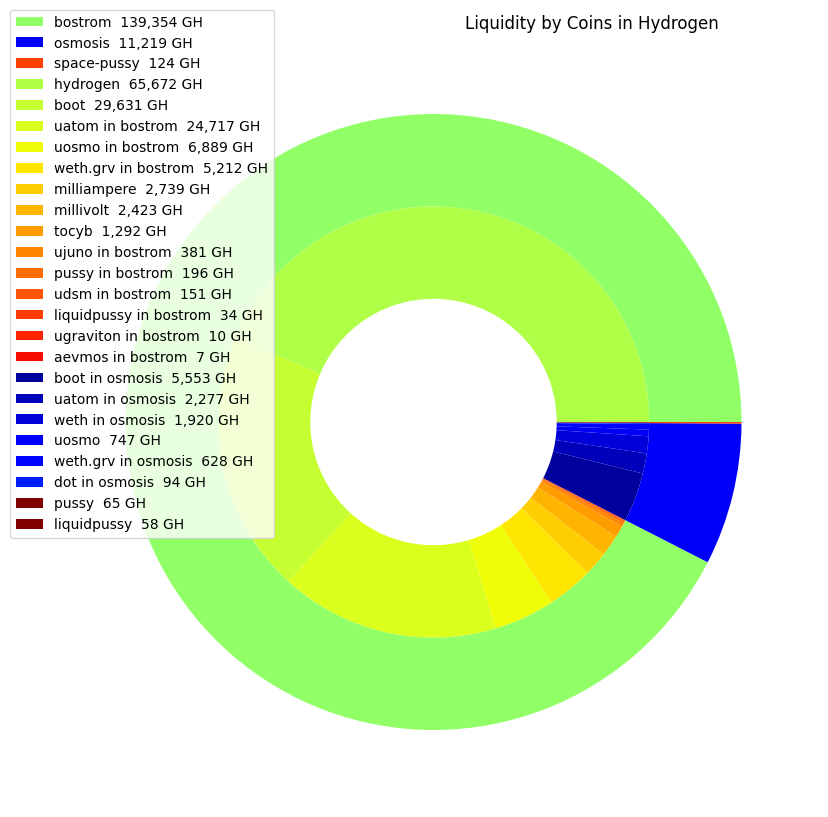

In [6]:
coin_list = set(chain(*pools_df.reserve_coin_denoms.to_list()))
coin_liquidity_data = []
print('Liquidity by Coins')
for coin_denom in coin_list:
    if coin_denom in ('milliampere', 'millivolt'):
        pools_df.loc[:, f'{coin_denom}_balance'] = pools_df[pools_df.network != 'space-pussy'].balances.map(lambda x: get_pool_value_by_coin(pool_balances=x, coin_denom=coin_denom))
    else:
        pools_df.loc[:, f'{coin_denom}_balance'] = pools_df.balances.map(lambda x: get_pool_value_by_coin(pool_balances=x, coin_denom=coin_denom))
    if coin_denom == 'uosmo' or coin_denom[-7:] == 'osmosis':
        network = 'osmosis'
    elif coin_denom[-5:] == 'pussy':
        network = 'space-pussy'
    else:
        network = 'bostrom'
    coin_liquidity_data.append({
        'coin': coin_denom,
        'network': network,
        'liquidity': pools_df[f"{coin_denom}_balance"].sum(),
        'liquidity, GH': pools_df[f"{coin_denom}_balance"].sum() * price_enriched_df.loc['hydrogen', coin_denom] / 1e9})
coin_liquidity_df = pd.DataFrame(coin_liquidity_data).sort_values('liquidity, GH', ascending=False).reset_index().drop(columns=['index'])
display(HTML(
    coin_liquidity_df.to_html(
                index=False, notebook=True, show_dimensions=False)))

fig, ax = plt.subplots(figsize=(10, 10))
size = 0.3
cm = plt.get_cmap("jet", 20)
cout = cm(np.array([10, 2, 16]))

outer = coin_liquidity_df.groupby('network')[
    'liquidity, GH'].sum().sort_index(
        axis=0, level=[0], ascending=[True], inplace=False)
inner = coin_liquidity_df[coin_liquidity_df['liquidity, GH'] > 1].groupby(
    ['network', 'coin'])['liquidity, GH'].sum().sort_values(ascending=False).sort_index(axis=0, level=[0],
                                                                                             ascending=[True],
                                                                                             inplace=False)
inner_labels = ['{1}  {2:>,.0f} GH'.format(i[0], i[1], j) for i, j in zip(inner.index, inner)]
outer_labels = ['{0}  {1:>,.0f} GH'.format(i, j) for i, j in zip(outer.index, outer)]
ax.pie(outer.values.flatten(), radius=1,
       labeldistance=0.73,
       wedgeprops=dict(width=size), colors=cout)
cm2 = plt.get_cmap("jet", 40)
cin = cm2(np.array(list(range(22, 36)) + list(range(1, 7)) + list(range(40, 45))))
ax.pie(inner.values.flatten(), radius=1 - size,
       wedgeprops=dict(width=size),
       labeldistance=0.5, colors=cin)

ax.set_title('Liquidity by Coins in Hydrogen                   ', loc='right')

plt.legend(outer_labels + inner_labels, loc=(-0.05, 0.35))
handles, labels = ax.get_legend_handles_labels()
plt.show()

coin_liquidity_df.to_csv('data/coins_liquidity.csv')